In [1]:
import numpy as np
np.random.seed(271828)
from os import system, environ
from pickle import dump, load, HIGHEST_PROTOCOL
import pandas as pd
from pprint import pprint
from glob import glob
import datetime as dt
from iminuit import Minuit
from iminuit.cost import LeastSquares

from plottools import *
import matplotlib.pyplot as plt
import matplotlib
from mplhep import histplot, style
style.use(style.LHCb2)
import matplotlib.dates as mdates
import matplotlib.patheffects as pe
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.ticker import *
# matplotlib.colormaps.register(name="beer", cmap=LinearSegmentedColormap.from_list("beer", colors=[niceColour('beeryellow'), niceColour('beerbrown')]))
import seaborn as sns

# import plotly.graph_objects as go
# from plotly.offline import iplot
# import plotly.io as pio
# pio.renderers.default='notebook'

import matplotlib.dates as mdates
import matplotlib.patheffects as pe
from matplotlib.ticker import *

In [2]:
# df = pd.read_csv("1202beers.csv", delimiter=';', encoding='utf-8')
df = pd.read_csv("1230beers.csv", delimiter=',', encoding='utf-8')
df = pd.read_csv("1407beers.csv", delimiter=';', encoding='utf-8')

In [3]:
###############################################################################
# Group by storage, which (somewhat) approximates countries of origin
###############################################################################
class Storage:
    def __init__(self, name: str, capacity: int, description: str, colour):
        self.name = name # identifier in the collection
        self.capacity = capacity # how big the album is
        self.description = description # description
        self.colour = colour if type(colour) == str else '#{:02x}{:02x}{:02x}'.format(*colour)# for plotting purposes
def rgb(r,g,b): return np.array([r,g,b]) # colour conversion & compatibility with colour-display addon

sChonkyBrown = Storage("Chonky brown", 650, "International", rgb(98,70,46))
sChonkyBrown2 = Storage("Chonky brown 2", 650, "Franco-Swiss", rgb(113,78,45)) 
sTallBlack = Storage("Tall black", 400, "Belgian", 'black')
sBigBrown = Storage("Big brown", 300, "British", rgb(165,87,49))
sGreen = Storage("Green", 300, "German", rgb(34,58,36))
sBlue = Storage("Blue", 200, "Romanian", clr.LHCbdblue)
sWhite = Storage("White", 200, "Hall of Fame", clr.onidgrey)
sRed = Storage("Red", 100, "Dutch", clr.claret)

# temporary albummates
df.loc[(df.Storage == 'Chonky brown')&((df.Country == 'FR')|(df.Country == 'CH')), 'Storage'] = "Chonky brown 2"


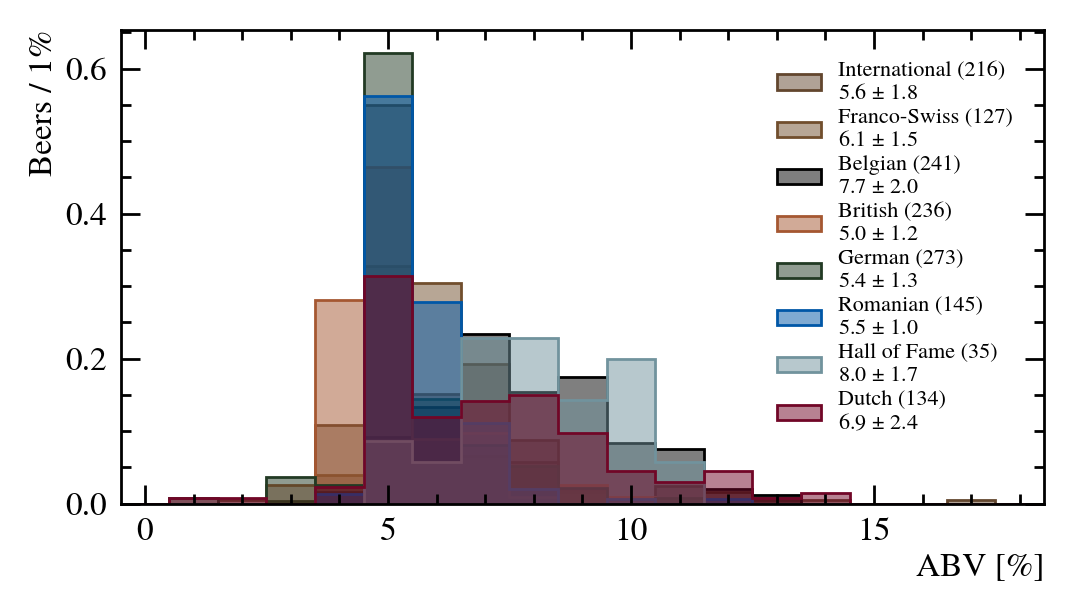

In [56]:
# ABV histogram
fig, ax = plt.subplots(figsize=(16*.66,9*.66))
plt.tight_layout()
plt.margins(x=0)
ps, ls = [], []
for storage in [sChonkyBrown, sChonkyBrown2, sTallBlack, sBigBrown, sGreen, sBlue, sWhite, sRed]:
    dS = df[df.Storage == storage.name]
    hABV = np.histogram(dS.ABV, np.linspace(-.5,18.5,20))
    muABV = np.mean(dS.ABV)
    stdABV = np.std(dS.ABV)
    label = storage.description + f' ({len(dS)})\n' + fr'{muABV:.1f} $\pm$ {stdABV:.1f}'
    plotBorderedHist(hABV, ps, ls, storage.colour, 0.5, label, density=True)
    plt.xlabel('ABV [%]')
    plt.ylabel("Beers / 1%")

applyUniformFont(ax,24)
leg = plotOrderedLegend(list(range(len(ps))), ps, ls, loc='upper right', fontsize=16)
plt.show()
# saveAndListPlot("histABV_storage.pdf", "Histogram of ABVs for each storage")

/Users/rm1613/Documents/ion-production-at-lhcb/venv-local/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


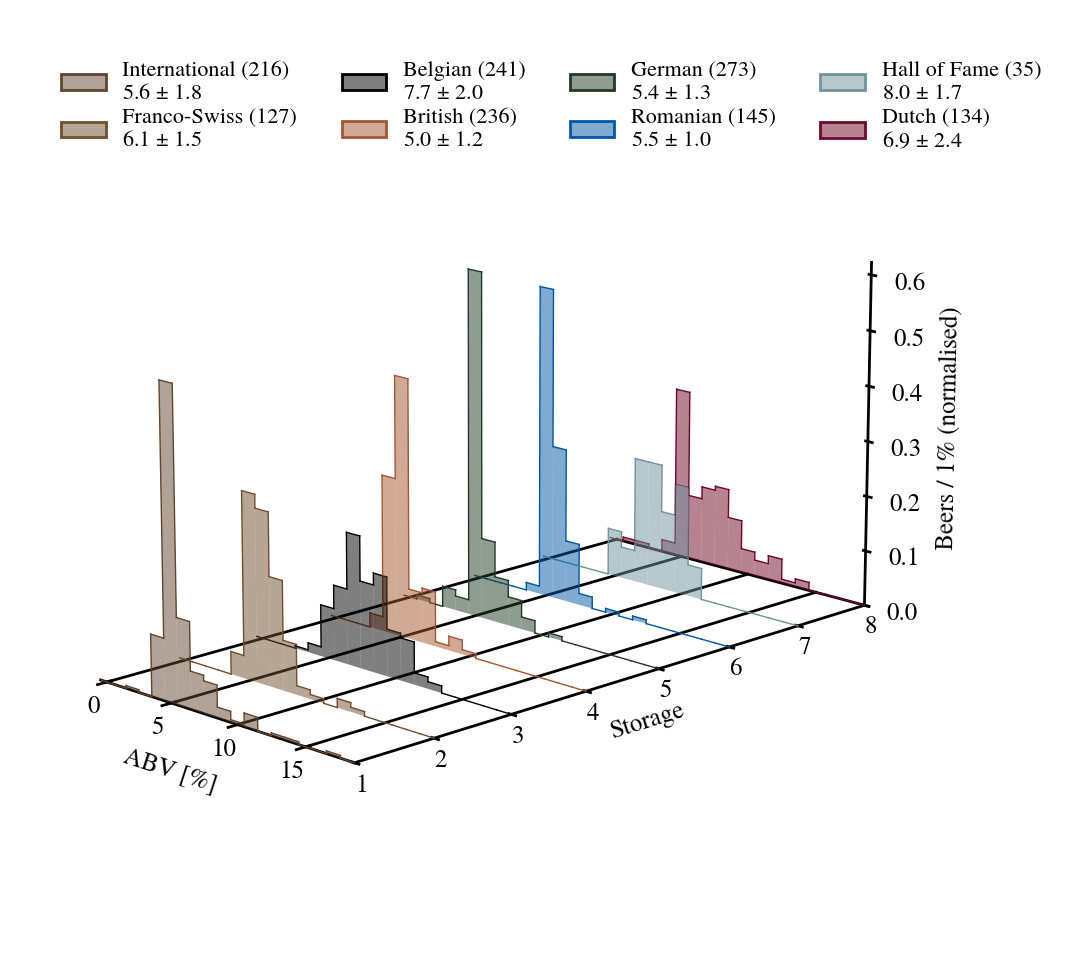

In [84]:
# do it in 3D
# NB: relies on the legend from the previous plot
binning = np.linspace(-.5,18.5,20)
nStorage = 8 + 1

# patch to adjust code for margins in 3D projections
###patch start###
from mpl_toolkits.mplot3d.axis3d import Axis
if not hasattr(Axis, "_get_coord_info_old"):
    def _get_coord_info_new(self, renderer):
        mins, maxs, centers, deltas, tc, highs = self._get_coord_info_old(renderer)
        mins += deltas / 4
        maxs -= deltas / 4
        return mins, maxs, centers, deltas, tc, highs
    Axis._get_coord_info_old = Axis._get_coord_info  
    Axis._get_coord_info = _get_coord_info_new
###patch end###

fig = plt.figure(figsize=(16,9))
ax = fig.add_axes([0,0,1,1], projection='3d')
ax.margins(x=0, y=0, z=0)
ax.set_box_aspect([3,6,3])
ax.view_init(elev=15, azim=-45)
ax.minorticks_off()
ax.zaxis.set_minor_locator(plt.NullLocator())
# ax.autoscale(axis='y', tight=False)

# Set a white background color
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))

for division in [0, 5, 10, 15,]: ax.plot([division]*(nStorage-1), range(1, nStorage), c='black', lw=2)
ax.plot([0, binning[-1]], [nStorage-1, nStorage-1], c='black', lw=2)
ax.set_xlabel('ABV [%]', labelpad=10)
ax.set_ylabel("Storage", labelpad=10)
ax.set_zlabel("Beers / 1% (normalised)", labelpad=15)

ax.grid(False)
plt.tick_params(axis='both', which='both', pad=0)
plt.tick_params(axis='z', which='both', pad=9)
applyUniformFont(ax, 18, in3d=True)

for i, storage in enumerate([sChonkyBrown, sChonkyBrown2, sTallBlack, sBigBrown, sGreen, sBlue, sWhite, sRed]):
    dS = df[df.Storage == storage.name]
    hABV, _ = np.histogram(dS.ABV, binning)
    norm = sum(hABV)*(binning[1]-binning[0])

    muABV = np.mean(dS.ABV)
    stdABV = np.std(dS.ABV)

    ax.bar(binning[:-1], hABV/norm, width=binning[1]-binning[0], color=storage.colour, align='edge', zs=i+1, zdir='y', alpha=.5)
    # Add outlines at the top of the bars
    for j in range(len(binning)-1): 
        ax.plot([binning[j], binning[j+1]], [hABV[j]/norm, hABV[j]/norm], zs=i+1, zdir='y', color=storage.colour, linewidth=1)
        ax.plot([binning[j], binning[j]], [hABV[j]/norm, hABV[j-1]/norm], zs=i+1, zdir='y', color=storage.colour, linewidth=1)

plotOrderedLegend(list(range(len(ps))), ps, ls, loc='upper left', fontsize=16, kwargs=dict(ncol=4))
plt.show()

In [49]:
leg.get_texts()[0]

Text(0, 0, 'International (216)\n5.6 $\\pm$ 1.8')

# Histogram of ABVs

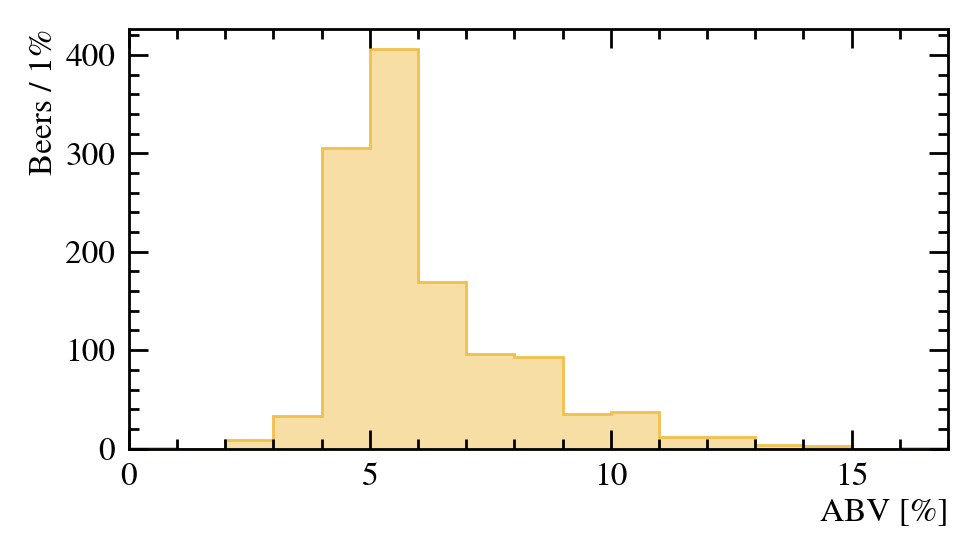

In [3]:
hABV = np.histogram(df.ABV, np.linspace(0,17,18))
fig, ax = plt.subplots(figsize=(16*.6,9*.6))
plt.tight_layout()
plt.margins(x=0)
histplot(hABV, color='#f1bf4b', histtype="fill", alpha=.5)
histplot(hABV, color='#f1bf4b', histtype="step")
plt.xlabel('ABV [%]')
plt.ylabel("Beers / 1%")
applyUniformFont(ax,24)
plt.show()
# plt.savefig("histABV.pdf", "Histogram of ABVs")
# plt.close()

# Histogram of countries

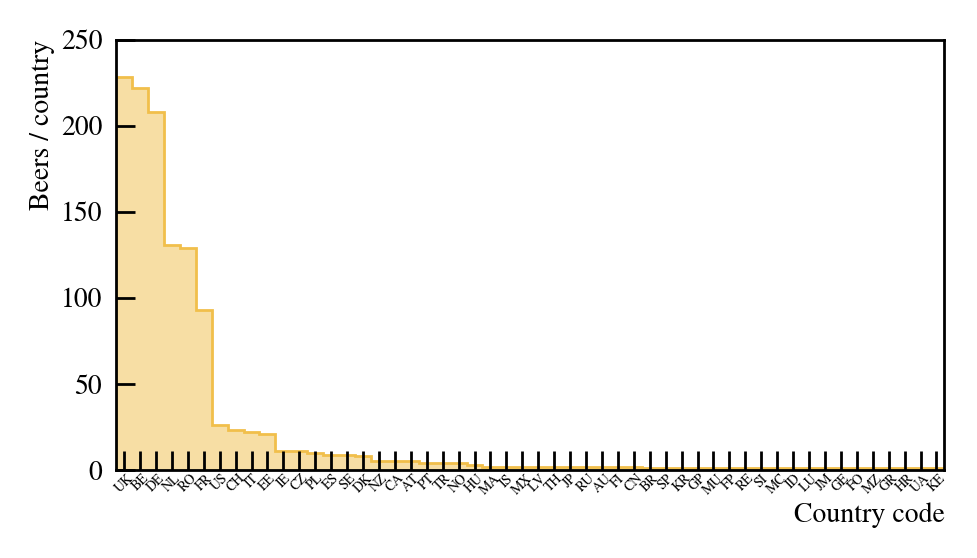

In [6]:
dg = df.Country.value_counts()
bins = np.linspace(0,len(dg),len(dg)+1)
fig, ax = plt.subplots(figsize=(16*.6,9*.6))
plt.tight_layout()
plt.margins(x=0)
histplot(dg, bins, color='#f1bf4b', histtype="fill", alpha=.5)
histplot(dg, bins, color='#f1bf4b', histtype="step")
ax.set_xticks(.5*(bins[1:]+bins[:-1]))
ax.minorticks_off()
plt.xlabel('Country code')
plt.ylabel("Beers / country")
applyUniformFont(ax,20)
ax.set_xticklabels(dg.index, fontsize=10, rotation=45)
plt.tick_params(axis='x', pad=1)
plt.tick_params(axis='both', top=False,right=False)
ax.set_ylim(top=250)
# ax.set_yscale('log')
plt.show()

# ABV per country

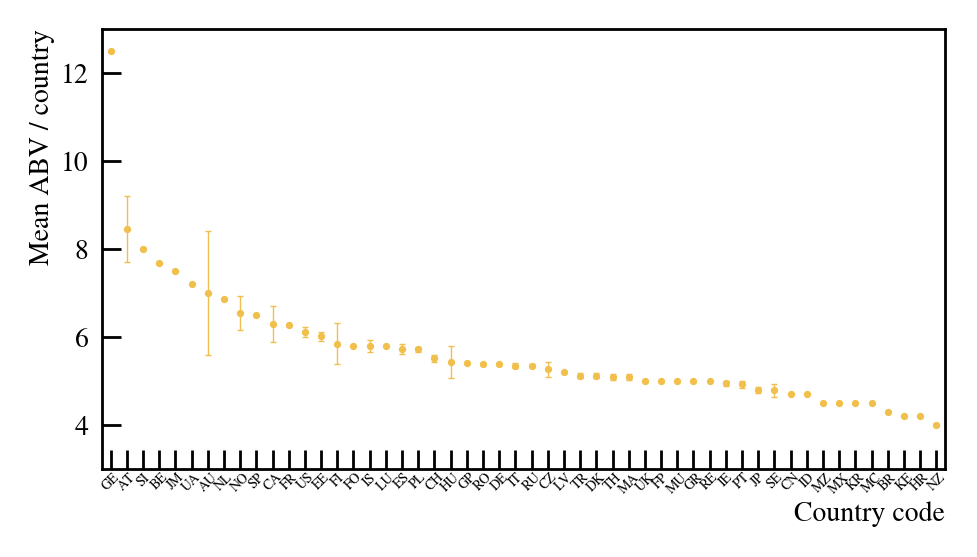

In [7]:
dGrp = df.groupby("Country")
means = dGrp.ABV.mean()
eoms = dGrp.ABV.std() / dGrp.ABV.count()
dh = pd.concat([means,eoms], keys=['MeanABV','ErrorOnABV'], axis=1)
dh = dh.sort_values('MeanABV',ascending=False)
fig, ax = plt.subplots(figsize=(16*.6,9*.6))
plt.tight_layout()
plt.margins(x=0.01)
plt.errorbar(.5*(bins[1:]+bins[:-1]), dh.MeanABV, dh.ErrorOnABV, False, ls='', marker='.', markersize=7.5, elinewidth=1, capthick=1, capsize=2.5, color='#f1bf4b')
ax.set_xticks(.5*(bins[1:]+bins[:-1]))
ax.minorticks_off()
plt.xlabel('Country code')
plt.ylabel("Mean ABV / country")
applyUniformFont(ax,20)
ax.set_xticklabels(dh.index, fontsize=10, rotation=45)
ax.set_ylim([3,13])
plt.tick_params(axis='x', pad=1)
plt.tick_params(axis='both', top=False,right=False)
plt.show()

In [8]:
dates = [dt.datetime(2018,3,27,0,0), dt.datetime(2019,9,26,0,0), dt.datetime(2020,12,8,0,0), dt.datetime(2021,6,27,0,0), dt.datetime(2022,1,27,0,0), dt.datetime(2025,1,1,0,0)]
locations = ['CERN', 'London', 'RO', 'London', 'DENL']
def plotLandmarkDates(y, zorder=-99):
    for i in range(len(locations)):
        plt.axvline(x=dates[i], c='#9C4431', ls='--', zorder=zorder) # F1DD59 # EED892
        plt.text(dates[i]+dt.timedelta(days=15), y, locations[i], c='w', va='top', zorder=zorder, path_effects=[pe.Stroke(linewidth=.5, foreground='#9C4431')])

# Time evolution

In [9]:
# Process the data
df['Date'] = pd.to_datetime(df['Date'], errors='coerce',format='%d/%m/%Y')
day0 = np.mean(df.Date).date()
dDates = df[pd.notna(df['Date'])][['Number','Date','ABV']]
dDates['usableDate'] = [(x.date() - dt.date(2018,1,1)).days for x in dDates['Date']]
dDates = dDates.query('usableDate > 0')
dDates = dDates[pd.notna(dDates['Number'])]
dDates['x'] = [(x.date() - day0).days for x in dDates['Date']]
# please the mathematicians
# dDates['costheta'] = dDates['x'] * 2 / (dDates.x.max() - dDates.x.min()) 
# dDates['y'] = dDates['Number'] * 2 / (dDates.Number.max() - dDates.Number.min())

# fit a 2nd order Chebychev polynomial
def cheby2(x, c0=0, c1=1, c2=0):
    return c0 + c1 * x + c2 * (2*x*x - 1)
# fit a 4thd order Chebychev polynomial
def cheby4(x, c0=0, c1=1, c2=0, c3=0, c4=0):
    return cheby2(x,c0,c1,c2) + \
    c3 * (4*x*x*x - 3*x) + \
    c4 * (8*x*x*x*x - 8*x*x - 1)

minimiser = Minuit(LeastSquares(np.array(dDates.x), np.array(dDates.Number), np.ones_like(dDates.Number), cheby4), 
    c0 = 600, 
    c1 = .5,
    c2 = 1e-5,
    c3 = 1e-5,
    c4 = 1e-5,
    )
result = minimiser.migrad()
param_hesse = result.hesse()
param_errors = result.errors
print(result)

fit_info = [
    f"$\\chi^2$ / $n_\\mathrm{{dof}}$ = {minimiser.fval:1.1e} / {len(dDates) - minimiser.nfit}",
]
for p, v, e in zip(minimiser.parameters, minimiser.values, minimiser.errors):
    if not minimiser.fixed[p]:
        fit_info.append(f"{p} = ${v:1.1e} \\pm {e:1.1e}$")

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1.556e+05 (chi2/ndof = 151.5)│              Nfcn = 197              │
│ EDM = 7.08e-18 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬────

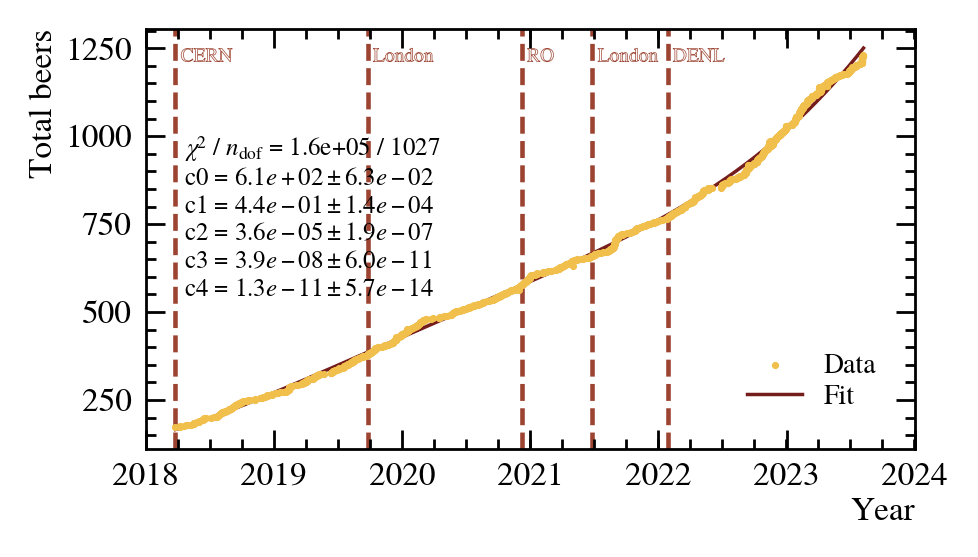

In [10]:
fig, ax = plt.subplots(figsize=(16*.6,9*.6))
plt.tight_layout()
plt.margins(x=0)
plt.xlabel('Year')
plt.ylabel('Total beers')
plt.plot(np.sort(dDates.Date), cheby4(np.sort(dDates.x), *minimiser.values), color='#751D1D', lw=2.5, zorder=-99, label='Fit')
plt.scatter(dDates.Date, dDates.Number, color='#f1bf4b', s=10, label='Data')
plotOrderedLegend([1,0])
ax.set_xlim([dt.date(2018,1,1), dt.date(2024,1,1)])
applyUniformFont(ax,24)
plotLandmarkDates(1250)
plt.text(.05,.75, "\n".join(fit_info), transform=ax.transAxes, fontsize=18, ha='left', va='top')
plt.show()

# Time evolution of mean ABV

In [11]:
def rollingMeanVariance(l, mu=0, v=0, i0=0):
    mus, vs = [], []
    n = len(l)
    for i in range(n):
        delta = l[i] - mu
        mu += delta / (i+1+i0)
        mus.append(mu)
        v += (l[i] - mu) * delta
        vs.append(v / (i+1+i0))
    return mus, vs

In [12]:
dh = df[pd.notna(df['ABV'])][['Number','Date','ABV']]
# start with the mean before dating
mBefore = [pd.isna(x) or (x.date() - dt.date(2018,1,1)).days < 0 for x in dh['Date']]
listBefore = np.sort(dh[mBefore]['ABV'])
mus, vs = rollingMeanVariance(listBefore)
mu0, v0 = mus[-1], vs[-1]
nBefore = len(dh[mBefore])

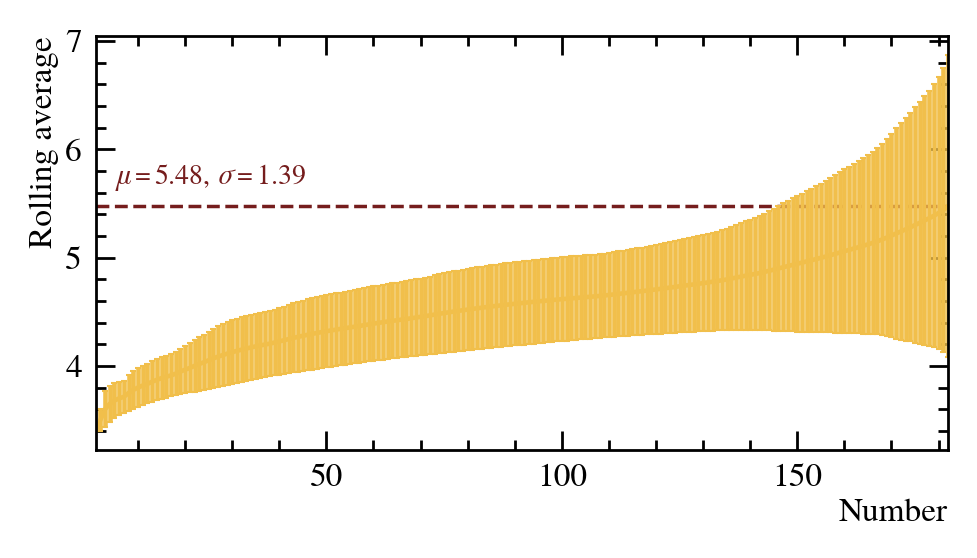

In [13]:
fig, ax = plt.subplots(figsize=(16*.6,9*.6))
plt.tight_layout()
plt.margins(x=0)
plt.xlabel('Number')
plt.ylabel('Rolling average')
# plt.errorbar(range(1,nBefore+1), mu0, vs0, color='#f1bf4b')
plt.axhline(y=mu0, color='#751D1D', lw=2.5, zorder=-99, ls='--')
plt.text(5, mu0+.2, f"$\\mu={mu0:.2f}$, $\\sigma={v0 **.5:.2f}$", color='#751D1D', fontsize=20)
plt.errorbar(range(1,nBefore+1), mus, np.sqrt(vs), color='#f1bf4b') # NB the error bars are not the error on the mean
applyUniformFont(ax,24)
plt.show()

In [14]:
# Continue with the entries that have a usable date
mAfter = [pd.notna(x) and (x.date() - dt.date(2018,1,1)).days > 0 for x in dh['Date']]
dAfter = dh[mAfter].sort_values('Date').reset_index()
listAfter = dAfter.ABV
nAfter = len(listAfter)
mus, vs = rollingMeanVariance(listAfter, mu0, v0*nBefore, nBefore)
mus.insert(0,mu0)
vs.insert(0,v0)
len(mus), nAfter
errs = []
for i in range(len(mus)):
    errs.append((vs[i]/(i+nBefore))**.5)

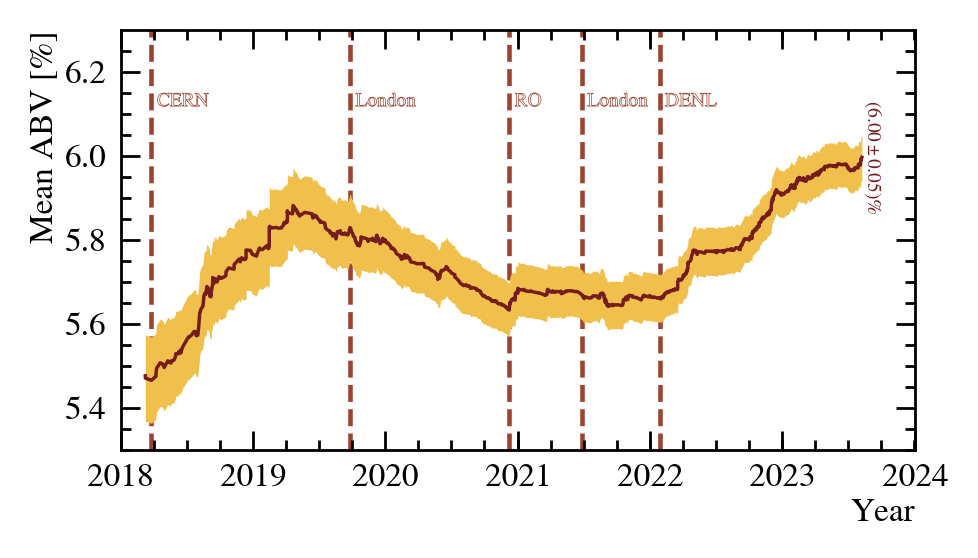

In [15]:
fig, ax = plt.subplots(figsize=(16*.6,9*.6))
plt.tight_layout()
plt.margins(x=0)
plt.xlabel('Year')
plt.ylabel('Mean ABV [%]')
# plt.errorbar([dAfter.Date[0]] + list(dAfter.Date), mus, errs, color='#f1bf4b', ls='',marker='.', markersize=.5, elinewidth=1, capthick=1, capsize=.5, lw=.5) 
ax.fill_between([dAfter.Date[0]] + list(dAfter.Date), np.array(mus)+errs, np.array(mus)-errs, color='#f1bf4b', lw=0)
p1 = ax.plot([dAfter.Date[0]] + list(dAfter.Date), mus, color='#751d1d', lw=2.5, label='bla')
plt.text(np.max(dAfter.Date), mus[-1], f"$({mus[-1]:.2f}\pm{errs[-1]:.2f})\\%$", color='#751d1d', va='center', rotation=-90, fontsize=14)
ax.set_xlim([dt.date(2018,1,1), dt.date(2024,1,1)])
ax.set_ylim([5.3,6.3])
plotLandmarkDates(6.15)
applyUniformFont(ax,24)
plt.show()

# Separation by (rough) location when drunk

In [16]:
mBefore = [pd.isna(x) or (x.date() - dt.date(2018,1,1)).days < 0 for x in df['Date']]
mAfter = [pd.notna(x) and (x.date() - dt.date(2018,1,1)).days > 0 for x in df['Date']]
d = df[mAfter]
d['Timestamp'] = [x.timestamp() for x in d['Date']]

dates = [dt.datetime(2018,3,27,0,0), dt.datetime(2019,9,26,0,0), dt.datetime(2020,12,8,0,0), dt.datetime(2021,6,27,0,0), dt.datetime(2022,1,27,0,0), dt.datetime(2025,1,1,0,0)]
timestamps = [x.timestamp() for x in dates]
locations = ['CERN', 'London', 'RO', 'London', 'DENL']
d['Location'] = pd.cut(d['Timestamp'], bins=timestamps, labels=locations, ordered=False)

/var/folders/dx/41cd57nj0wd7ssx9b1z74rjc0000gn/T/ipykernel_5626/2915290294.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/dx/41cd57nj0wd7ssx9b1z74rjc0000gn/T/ipykernel_5626/2915290294.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



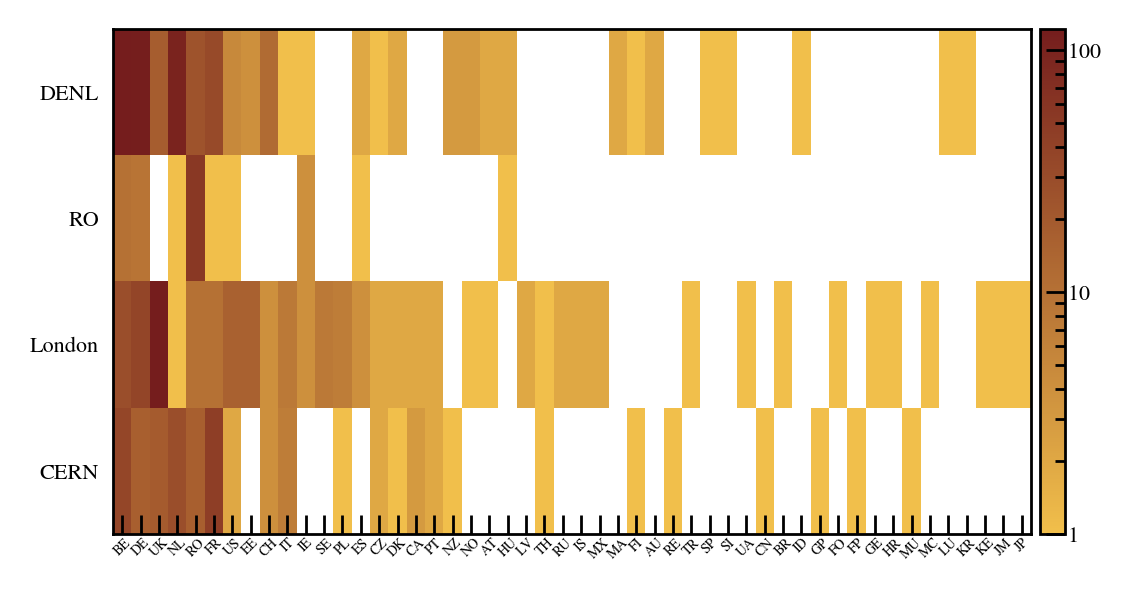

In [17]:
counts = d['Country'].value_counts()
d = d[d['Country'].isin(counts.index)].sort_values(by='Country', key=lambda x: x.map(counts), ascending=False)

xtab = pd.crosstab(d.Location, d.Country)
xtab = xtab[xtab.sum().sort_values(ascending=False).index].reindex(['CERN','London','RO','DENL'][::-1])
fig, ax = plt.subplots(figsize=(18*.6,9*.6), layout='constrained')
plt.margins(x=0)
im = ax.imshow(xtab, aspect='auto', rasterized=True, norm=LogNorm(), 
              cmap=LinearSegmentedColormap.from_list("beer",colors=['#f1bf4b','#751d1d']))
locs = xtab.index.tolist()
countries = xtab.columns.tolist()

# Set axis labels and tick positions
plt.yticks(range(len(locs)), locs)
applyUniformFont(ax,16)
plt.xticks(range(len(countries)), countries, rotation=45, fontsize=10)
plt.minorticks_off()
plt.tick_params(axis='x', pad=1),
plt.tick_params(axis='both', top=False,right=False, left=False)

cbar = fig.colorbar(im, shrink=1., pad=.01)
cbar.ax.tick_params(axis='both', pad=1)
applyUniformFont(cbar.ax,16)
plt.show()

In [18]:
xtab

Country,BE,DE,UK,NL,RO,FR,US,EE,CH,IT,...,FP,GE,HR,MU,MC,LU,KR,KE,JM,JP
Location,,,,,,,,,,,,,,,,,,,,,
DENL,122,116,18,98,24,32,5,4,12,1,...,0,0,0,0,0,1,1,0,0,0
RO,10,9,0,1,54,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
London,28,37,122,1,10,10,16,16,4,8,...,0,1,1,0,1,0,0,1,1,1
CERN,36,17,19,28,17,45,2,0,4,7,...,1,0,0,1,0,0,0,0,0,0


# Time between 100s

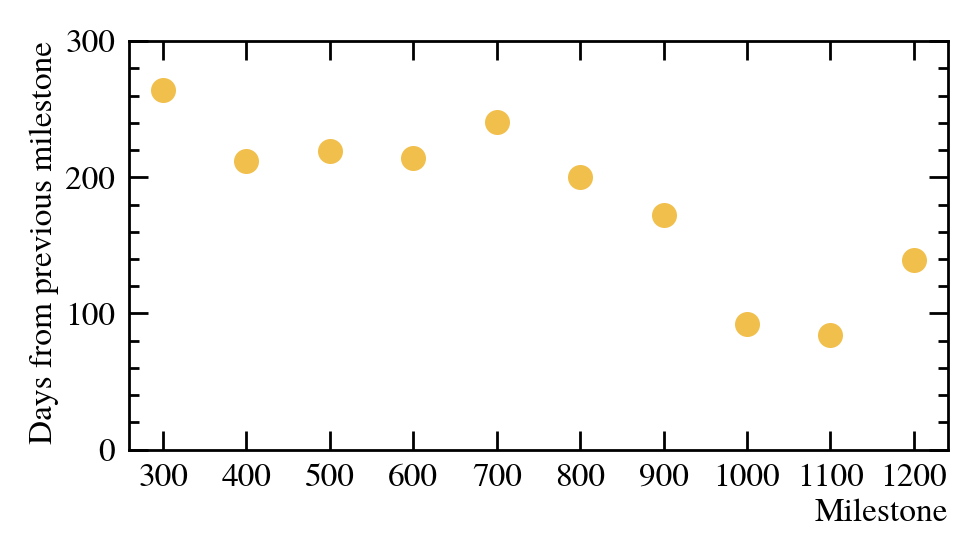

In [19]:
d100 = df[df.Number%100==0].sort_values(by='Number').reset_index(drop=True)
fig, ax = plt.subplots(figsize=(16*.6,9*.6))
plt.tight_layout()
plt.margins(x=50/(max(d100.Number)-min(d100.Number)+100))
plt.xlabel('Milestone')
plt.ylabel('Days from previous milestone')
plt.scatter(np.arange(min(d100.Number)+100, max(d100.Number)+1, 100), [x.days for x in d100['Date'].diff()][1:], color=niceColour('beeryellow'))
ax.xaxis.set_major_locator(MultipleLocator(100))
ax.xaxis.set_minor_locator(NullLocator())
ax.set_ylim([0,300])
applyUniformFont(ax, 24)
plt.show()

# How many beers were drunk in a given day

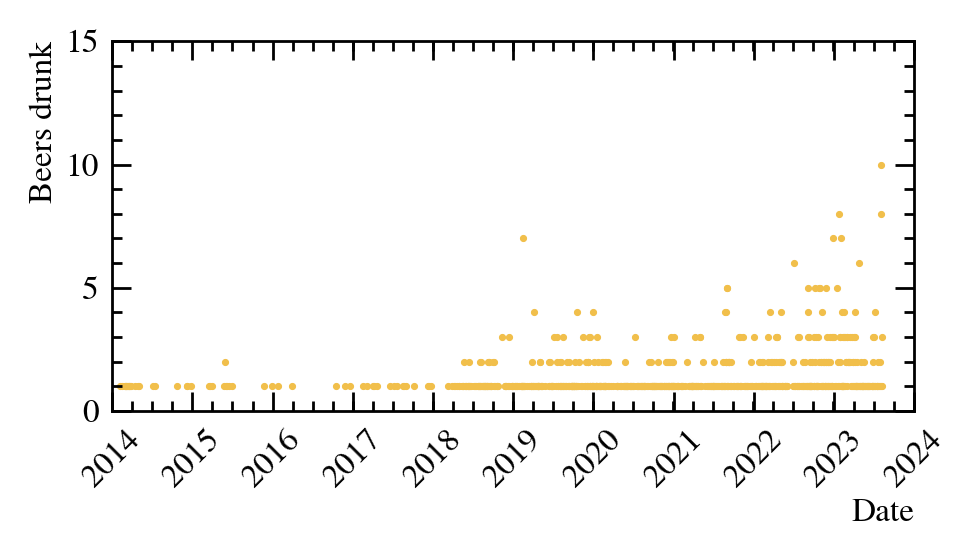

In [21]:
dGrp = df.groupby('Date')
bdrunk = dGrp.size()
# bdrunk.index
fig, ax = plt.subplots(figsize=(16*.6,9*.6))
plt.tight_layout()
plt.margins(x=0)
ax.set_xlabel("Date")
ax.set_ylabel("Beers drunk")
ax.set_ylim([0,15])
ax.set_xlim([dt.date(2014,1,1), dt.date(2024,1,1)])
plt.xticks(rotation=45)
# ax.xaxis.set_major_locator(MaxNLocator(nbins=10))
# ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%Y'))
plt.scatter(bdrunk.index, bdrunk, s=10, c=niceColour("beeryellow"))
applyUniformFont(ax,24)
plt.show()

In [163]:
hdrunk = bdrunk.value_counts()
errs = np.sqrt(hdrunk.values)
binningFine = np.linspace(.5, max(hdrunk.index)+.5, 100*max(hdrunk.index)+1)

# fit an exponential or a power-law
def expo(x, N=1, l=0): return N*np.exp(-l*(x-1))
def pwr(x, N=1, n=0): return N*x**(-n)

minimiser = Minuit(LeastSquares(hdrunk.index, hdrunk.values, errs, 
                                # expo), N=hdrunk[0][0], l=1)
                                pwr), N=hdrunk.values[0], n=1)
result = minimiser.migrad()
param_hesse = result.hesse()
param_errors = result.errors
print(result)

fit_info = [
    f"$\\chi^2$ / $n_\\mathrm{{dof}}$ = {minimiser.fval:1.1e} / {len(hdrunk.values) - minimiser.nfit}",
]
for p, v, e in zip(minimiser.parameters, minimiser.values, minimiser.errors):
    if not minimiser.fixed[p]:
        fit_info.append(f"{p} = ${v:1.1e} \\pm {e:1.1e}$")

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 12.97 (chi2/ndof = 1.9)    │              Nfcn = 126              │
│ EDM = 1.07e-09 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬──────

/var/folders/dx/41cd57nj0wd7ssx9b1z74rjc0000gn/T/ipykernel_5626/3875742464.py:7: RuntimeWarning:

overflow encountered in power



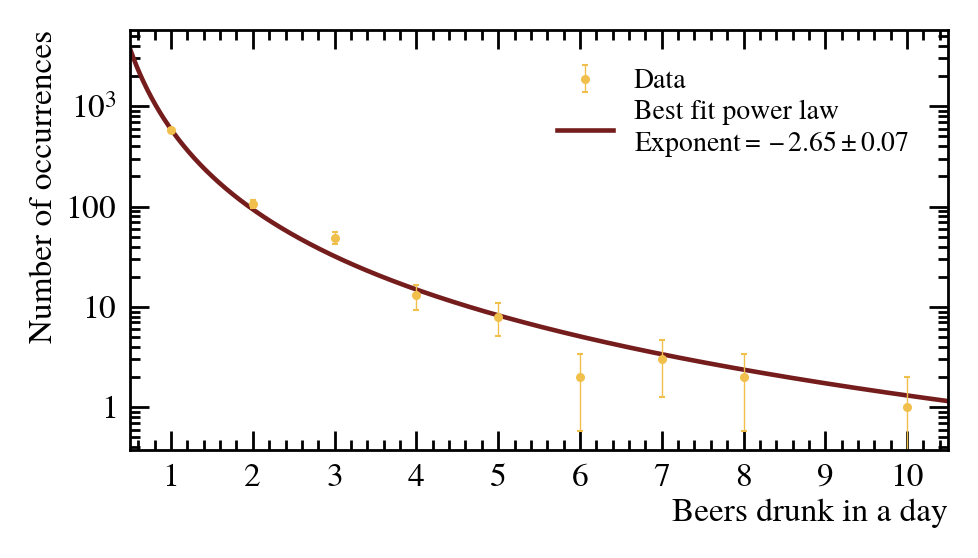

In [181]:
fig, ax = plt.subplots(figsize=(16*.6,9*.6))
plt.tight_layout()
plt.margins(x=0)
ax.set_xlabel("Beers drunk in a day")
ax.set_ylabel("Number of occurrences")
plt.plot(binningFine, pwr(binningFine, *minimiser.values), c=niceColour("beerbrown"), 
         label="Best fit power law\n"f"Exponent$=-{minimiser.values['n']:.2f}\pm{minimiser.errors['n']:.2f}$")
plt.errorbar(hdrunk.index, hdrunk.values, errs, c=niceColour("beeryellow"), ls='', marker='.', markersize=10., capsize=2.5, elinewidth=1, label='Data')
ax.set_xticks(np.linspace(1, max(hdrunk.index), max(hdrunk.index)))

plotOrderedLegend([1,0], loc=1)

ax.set_yscale('log')
applyUniformFont(ax,24)
plt.show()

In [178]:
sum(hdrunk.values)

765

In [180]:
from plottools import pdgRound

ImportError: cannot import name 'pdgRound' from 'plottools' (/Users/rm1613/Documents/misc/studyBeers/plottools.py)